In [3]:
using Pkg
Pkg.activate("..")

using 
    Printf,
    PyPlot, 
    PyPlotPlus,
    JLD2, 
    Interpolations, 
    FileIO, 
    NetCDF,
    SqueezeDispersion.Samoan

usecmbright()

In [5]:
# Load CTD and VMP data
filepath = joinpath("..", "data", "samoanpassagedata.jld2")
ctd = load(filepath, "ctd")
vmp = load(filepath, "vmp")

#ctdcast, ctdlon, ctdlat, ctdp, ctdt, ctdsp, ctdsigma4, ctddepth = unpacksection9(ctd)
ctdlon = ctd["lon"]
ctdlat = ctd["lat"]
ctdsigma4 = ctd["sigma4"]
ctddepth = ctd["depth"]

nz, nctd = size(ctdsigma4)
nvmp = length(vmp)

# Load bathymetric data
bathypath = joinpath("..", "data", "bathy.nc")
bathy = Dict()
bathy[:lat] = ncread(bathypath, "lat")
bathy[:lon] = ncread(bathypath, "lon")
bathy[:z] = -ncread(bathypath, "z")

lat1 = minimum(bathy[:lat])
lat2 = maximum(bathy[:lat])
lon1 = minimum(bathy[:lon])
lon2 = maximum(bathy[:lon])

# Clockwise:
left = latlondist(lat1, lon1, lat2, lon1)
top = latlondist(lat2, lon1, lat2, lon2)
right = latlondist(lat2, lon2, lat1, lon2)
bottom = latlondist(lat1, lon2, lat1, lon1)

@printf("lats: (%.2f, %.2f), lons: (%.2f, %.2f)\n", lat1, lat2, lon1, lon2)
@printf("left: %.2f, top: %.2f, right: %.2f, bottom: %.2f\n", left*1e-3, top*1e-3, right*1e-3, bottom*1e-3)
@printf("nctd: %d, nvmp: %d", nvmp, nctd)

lats: (-11.00, -6.50), lons: (-171.50, -167.50)
left: 11262.69, top: 13809.73, right: 11262.69, bottom: 50.84
nctd: 13, nvmp: 18

In [7]:
# Plot parameters
ms = 7
alpha = 1.0
profilealpha = 0.4
ctdcolor = "xkcd:lilac"
ctdsigmacolor = "blue"
vmpcolor = "xkcd:pale yellow"
vmpsigmacolor = "red"
ctdlw = 0.5
xtext = 0.0
ytext = 1.02
fs = 14
levels = 4000:200:6000

# Stripes
sigma1 = 45.84
sigma2 = 45.86
sigma3 = 45.96
sigma4 = 46.0
xbox = zeros(Float64, 1, 2)
ybox = zeros(Float64, 2, 1)
ybox[:, 1] = [3000, 6000]

sigmatop = 45.86
sigmabot = 45.96
dsigma = 0.005
layers = sigmatop:dsigma:sigmabot
layeredges = cat([sigmatop-dsigma/2], 0.5*(layers[2:end] + layers[1:end-1]), [sigmabot+dsigma/2], dims=1)
nlayers = length(layers)
buffer = 0.0005
switch = false
color1 = "xkcd:sky blue"
color2 = "xkcd:white";

┌ Warning: The default `strides(a::AbstractArray)` implementation is deprecated for general arrays.
│ Specialize `strides(::LinearAlgebra.Adjoint)` if `LinearAlgebra.Adjoint` indeed uses a strided representation in memory.
│ Warning: inappropriately implementing this method for an array type that does not use strided
│ storage may lead to incorrect results or segfaults.
│   caller = stride at abstractarray.jl:350 [inlined]
└ @ Core ./abstractarray.jl:350
┌ Warning: The default `strides(a::AbstractArray)` implementation is deprecated for general arrays.
│ Specialize `strides(::LinearAlgebra.Adjoint)` if `LinearAlgebra.Adjoint` indeed uses a strided representation in memory.
│ Warning: inappropriately implementing this method for an array type that does not use strided
│ storage may lead to incorrect results or segfaults.
│   caller = ip:0x0
└ @ Core :-1


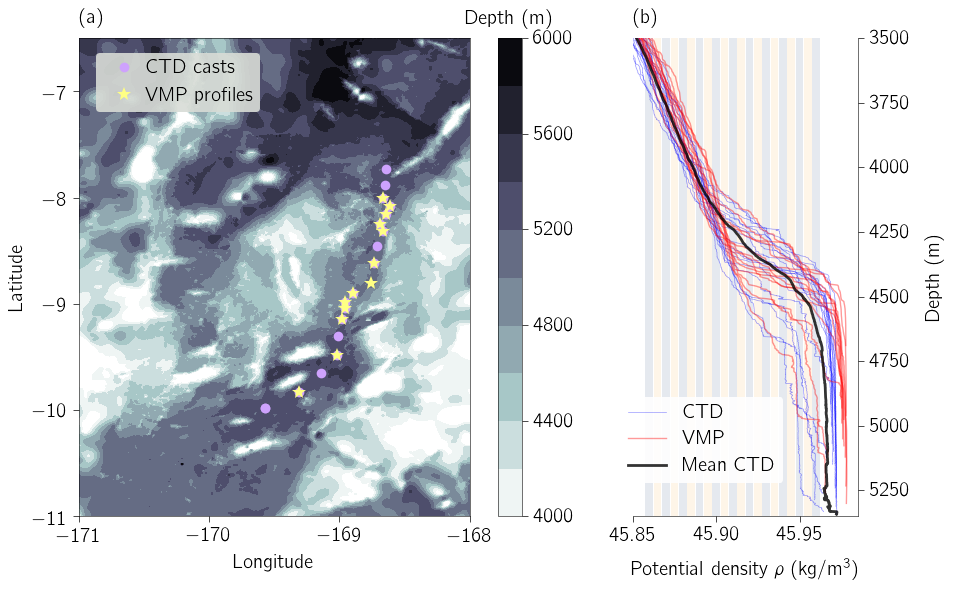

In [8]:
fig, axs = subplots(ncols=2, figsize=(10, 6), gridspec_kw=Dict("width_ratios"=>[2.5, 1]))

sca(axs[1])
contourf(bathy[:lon], bathy[:lat], -bathy[:z]', levels=levels, cmap="bone_r") #, linestyles="solid", linewidths=0.5, alpha=0.8)

# CTD casts in passage
plot(ctdlon, ctdlat, "o", color=ctdcolor, markeredgecolor="none",
     markeredgewidth=2, markersize=ms, alpha=alpha) 
# For labeling
plot(ctdlon[1], ctdlat[1], "o", color=ctdcolor, markeredgecolor="none",
     markeredgewidth=2, markersize=ms, label="CTD casts", alpha=alpha)

# VMP casts
label = "VMP profiles"
for (name, profile) in vmp
    plot(profile["lon"], profile["lat"], "*", color=vmpcolor, #fillstyle="none", 
         label=label, markersize=1.5*ms, markeredgewidth=1.5, markeredgecolor="none", alpha=alpha)
    label = nothing
end

# Mean density
sca(axs[2])

plot(ctdsigma4, ctddepth, color=ctdsigmacolor, linewidth=ctdlw, alpha=profilealpha)
plot(ctdsigma4[1], ctddepth[1], color=ctdsigmacolor, linewidth=ctdlw, alpha=profilealpha, label="CTD")

label="VMP"
for (name, profile) in vmp
    plot(profile["sgth4"], profile["depth"], linewidth=1.0, vmpsigmacolor, alpha=profilealpha, label=label)
    label=nothing
end

plot(dropdims(nanmean(ctdsigma4, 2), dims=2), ctddepth, "k-", linewidth=2.0, alpha=0.8, label="Mean CTD")

# Stripes
for i = 1:2:nlayers
    s1 = layeredges[i] + buffer
    s2 = layeredges[i+1] - buffer
    xbox[1, :] = [s1, s2]
    pcolormesh(xbox, ybox, ones(2, 2), cmap="Blues_r", alpha=0.1, edgecolor="None")
end

println()
for i = 2:2:nlayers
    s1 = layeredges[i] + buffer
    s2 = layeredges[i+1] - buffer
    xbox[1, :] = [s1, s2]
    pcolormesh(xbox, ybox, ones(2, 2), cmap="OrRd", alpha=0.4, edgecolor="None")
    clim(0.85, 2)
end

# Formatting for axis 1
sca(axs[1])
xlim(-171, -168)
ylim(-10.5, -6.5)
#clim(-5400, -4000)
cb = colorbar()
cb[:ax][:set_title]("Depth (m)", fontdict=Dict("verticalalignment"=>"bottom"))
leg = legend(loc="upper left", bbox_to_anchor=(0.02, 0.99), markerscale=1, frameon=true, facecolor="xkcd:light grey", 
             framealpha=0.9, handletextpad=0.1, edgecolor="None")
for text in leg[:get_texts]()
    text[:set_color]("black")
end
aspectratio(left/top)

xticks(-171:-168)
yticks(-11:-7)
xlabel("Longitude", labelpad=8.0)
ylabel("Latitude")

# Formatting for axis 2
sca(axs[2])
ylim(3500, 5350)
xlim(45.85, 45.985)
invertaxis()
cornerspines(side="right")
axisright()
legend(loc="lower left", bbox_to_anchor=(-0.1, 0.05), frameon=true, framealpha=0.9, edgecolor="None")
xlabel("Potential density \$ \\rho \$ (\$ \\mathrm{kg/m^3} \$)", labelpad=12.0)
ylabel("Depth (m)", labelpad=12.0)

# Finishing touches
text(xtext, ytext, "(a)", transform=axs[1][:transAxes], ha="left", va="bottom", fontsize=fs)
text(xtext, ytext, "(b)", transform=axs[2][:transAxes], ha="left", va="bottom", fontsize=fs)

tight_layout(w_pad=2.0)

plotname = "samoanoverview.png"
savefig(plotname, dpi=960)